# 오토인코더와 GAN을 사용한 표현 학습과 생성적 학습

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
try:
    IS_COLAB = True
except Exception:
    IS_COLAB = False
import tensorflow as tf
from tensorflow import keras

if not tf.config.list_physical_devices('GPU'):
    print('감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.')
    if IS_COLAB:
        print('런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.')
# 공통 모듈 임포트
import numpy as np
import os
# 깔끔한 그래프 출력을 위해
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('그림 저장 ' + fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution, format=fig_extension)

28x28 흑백 이미지를 그리기 위한 유틸리티 함수:

In [2]:
def plot_image(image):
    plt.imshow(image, 'binary')
    plt.axis('off')

## 과소완전 선형 오토인코더로 PCA 수행하기

3D 데이터셋을 만든다:

In [3]:
def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data


X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(0)

오토인코더를 만든다.

In [4]:
encoder = keras.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.Sequential([encoder, decoder])
autoencoder.compile(keras.optimizers.experimental.SGD(1.5), 'mse')

In [5]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 3s 4ms/step - loss: 1.0342
Epoch 2/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1103
Epoch 3/20
2/2 [==============================] - 0s 6ms/step - loss: 0.0690
Epoch 4/20
2/2 [==============================] - 0s 4ms/step - loss: 0.1030
Epoch 5/20
2/2 [==============================] - 0s 3ms/step - loss: 0.1073
Epoch 6/20
2/2 [==============================] - 0s 5ms/step - loss: 0.0421
Epoch 7/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0254
Epoch 8/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 9/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0117
Epoch 10/20
2/2 [==============================] - 0s 3ms/step - loss: 0.0089
Epoch 11/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 12/20
2/2 [==============================] - 0s 4ms/step - loss: 0.0071
Epoch 13/20
2/2 [==============================] - 0s 5ms/step - loss: 0.

In [6]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 2ms/step


그림 저장 linear_autoencoder_pca_plot


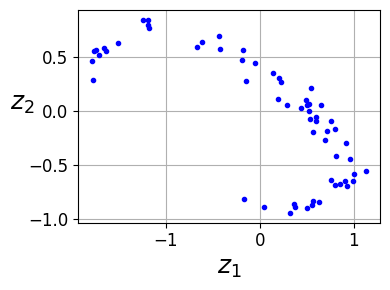

In [7]:
fig = plt.figure(figsize=(4, 3))
plt.plot(codings[:, 0], codings[:, 1], 'b.')
plt.xlabel('$z_1$', fontsize=18)
plt.ylabel('$z_2$', fontsize=18, rotation=0)
plt.grid(True)
save_fig('linear_autoencoder_pca_plot')
plt.show()

## 적층 오토인코더

### 케라스를 사용하여 적층 오토인코더 구현하기

MNIST 데이터셋을 사용한다:

In [8]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [9]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((55000, 28, 28), (55000,), (5000, 28, 28), (5000,), (10000, 28, 28), (10000,))

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [10]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.math.round(y_true), tf.math.round(y_pred))

In [11]:
stacked_encoder = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), keras.layers.Dense(100, 'selu'), keras.layers.Dense(30, 'selu')]
)
stacked_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
stacked_ae = keras.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))
history = stacked_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3375 - rounded_accuracy: 0.8878 - val_loss: 0.3122 - val_rounded_accuracy: 0.9111
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3059 - rounded_accuracy: 0.9149 - val_loss: 0.3025 - val_rounded_accuracy: 0.9195
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2985 - rounded_accuracy: 0.9216 - val_loss: 0.2968 - val_rounded_accuracy: 0.9237
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2940 - rounded_accuracy: 0.9258 - val_loss: 0.2952 - val_rounded_accuracy: 0.9285
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2913 - rounded_accuracy: 0.9281 - val_loss: 0.2913 - val_rounded_accuracy: 0.9303
Epoch 6/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2894 - rounded_accuracy: 0.9298 - val_loss: 0.2935 - val_rounded_accuracy: 0.9302


### 재구성 시각화

이 함수는 오토인코더를 사용해 몇 개의 테스트 이미지를 처리한다. 그런 다음 원본 이미지와 재구성 이미지를 그린다:

In [12]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

1/1 [==============================] - 0s 65ms/step
그림 저장 reconstruction_plot


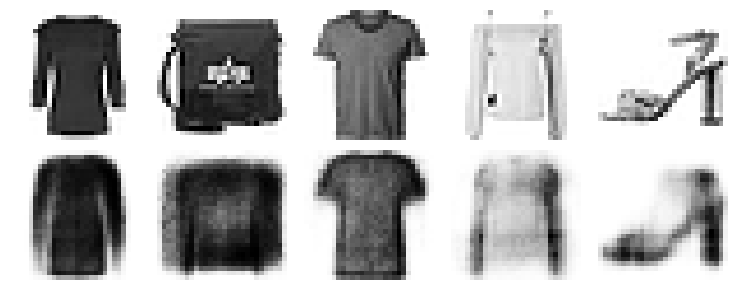

In [13]:
show_reconstructions(stacked_ae)
save_fig('reconstruction_plot')

### 패션 MNIST 데이터셋 시각화

In [14]:
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

157/157 [==============================] - 0s 879us/step


C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\kyun\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


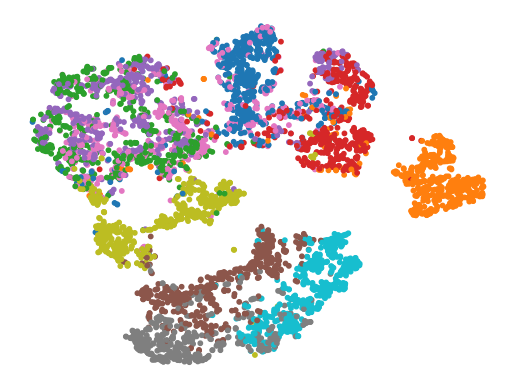

In [15]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 10, y_valid, cmap='tab10')
plt.axis('off')
plt.show()

이 그림을 조금 더 예쁘게 그린다:

그림 저장 fashion_mnist_visualization_plot


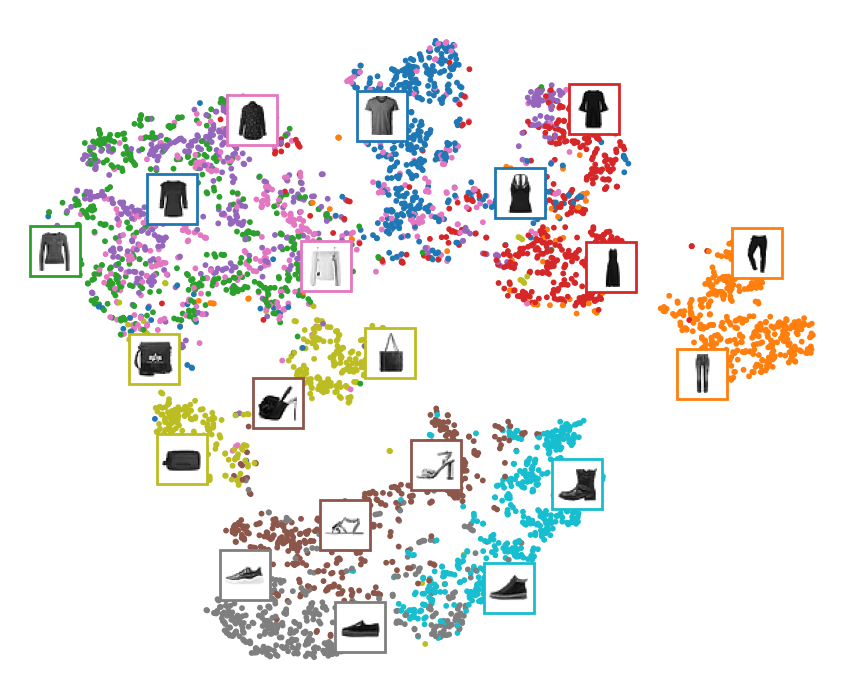

In [16]:
# https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html 참고
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], 10, y_valid, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, 1)
    if np.amin(dist) > 0.02:  # 다른 이미지에서 충분히 멀리 떨어져 있는 경우
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap='binary'),
            position,
            bboxprops={'edgecolor': cmap(y_valid[index]), 'lw': 2}
        )
        plt.gca().add_artist(imagebox)
plt.axis('off')
save_fig('fashion_mnist_visualization_plot')
plt.show()

### 가중치 묶기

인코더의 가중치를 전치(transpose)하여 디코더의 가중치로 사용하는 식으로 인코더와 디코더의 가중치를 묶는 일은 흔하다. 이렇게 하려면 사용자 정의 층을 사용해야 한다.

In [17]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.biases = None
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight('bias', [self.dense.input_shape[-1]], initializer='zeros')
        super().build(batch_input_shape)

    def call(self, inputs):
        z = tf.linalg.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

In [18]:
keras.backend.clear_session()
dense_1 = keras.layers.Dense(100, 'selu')
dense_2 = keras.layers.Dense(30, 'selu')
tied_encoder = keras.Sequential([keras.layers.Flatten(input_shape=[28, 28]), dense_1, dense_2])
tied_decoder = keras.Sequential(
    [DenseTranspose(dense_2, 'selu'), DenseTranspose(dense_1, 'sigmoid'), keras.layers.Reshape([28, 28])]
)
tied_ae = keras.Sequential([tied_encoder, tied_decoder])
tied_ae.compile(keras.optimizers.experimental.SGD(1.5), 'binary_crossentropy', [rounded_accuracy])
# history = tied_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = tied_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3265 - rounded_accuracy: 0.8964 - val_loss: 0.3017 - val_rounded_accuracy: 0.9204
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2967 - rounded_accuracy: 0.9231 - val_loss: 0.2946 - val_rounded_accuracy: 0.9246
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2915 - rounded_accuracy: 0.9278 - val_loss: 0.2927 - val_rounded_accuracy: 0.9247
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2886 - rounded_accuracy: 0.9305 - val_loss: 0.2879 - val_rounded_accuracy: 0.9330
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2867 - rounded_accuracy: 0.9322 - val_loss: 0.2865 - val_rounded_accuracy: 0.9342
Epoch 6/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2851 - rounded_accuracy: 0.9337 - val_loss: 0.3012 - val_rounded_accuracy: 0.9257


1/1 [==============================] - 0s 67ms/step


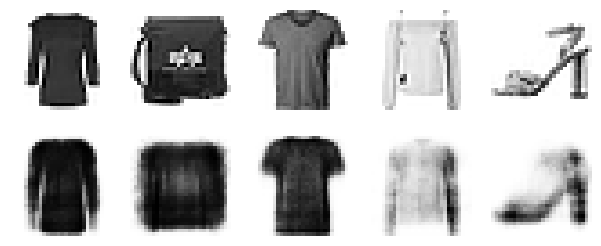

In [19]:
show_reconstructions(tied_ae)
plt.show()

### 한 번에 오토인코더 한 개씩 훈련하기

In [20]:
def train_autoencoder(n_neurons, X_train, X_valid, loss, optimizer, n_epochs=10, output_activation=None, metrics=None):
    n_inputs = X_train.shape[-1]
    encoder = keras.Sequential([keras.layers.Dense(n_neurons, 'selu', input_shape=[n_inputs])])
    decoder = keras.Sequential([keras.layers.Dense(n_inputs, output_activation)])
    autoencoder = keras.Sequential([encoder, decoder])
    autoencoder.compile(optimizer, loss, metrics)
    autoencoder.fit(X_train, X_train, epochs=n_epochs, validation_data=(X_valid, X_valid))
    return encoder, decoder, encoder(X_train), encoder(X_valid)

In [21]:
K = keras.backend
X_train_flat = K.batch_flatten(X_train)  # .reshape(-1, 28 * 28)과 동일
X_valid_flat = K.batch_flatten(X_valid)
enc1, dec1, X_train_enc1, X_valid_enc1 = train_autoencoder(
    100,
    X_train_flat,
    X_valid_flat,
    'binary_crossentropy',
    keras.optimizers.experimental.SGD(1.5),
    # output_activation='sigmoid',
    # metrics=[rounded_accuracy]
    8,
    'sigmoid',
    [rounded_accuracy]
)
enc2, dec2, _, _ = train_autoencoder(
    30, X_train_enc1, X_valid_enc1, 'mse', keras.optimizers.experimental.SGD(0.05), output_activation='selu'
)

Epoch 1/8
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3445 - rounded_accuracy: 0.8875 - val_loss: 0.3122 - val_rounded_accuracy: 0.9149
Epoch 2/8
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3039 - rounded_accuracy: 0.9203 - val_loss: 0.3007 - val_rounded_accuracy: 0.9249
Epoch 3/8
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2951 - rounded_accuracy: 0.9284 - val_loss: 0.2937 - val_rounded_accuracy: 0.9311
Epoch 4/8
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2895 - rounded_accuracy: 0.9338 - val_loss: 0.2893 - val_rounded_accuracy: 0.9359
Epoch 5/8
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2859 - rounded_accuracy: 0.9373 - val_loss: 0.2863 - val_rounded_accuracy: 0.9386
Epoch 6/8
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2833 - rounded_accuracy: 0.9398 - val_loss: 0.2840 - val_rounded_accuracy: 0.9407
Epoch 7/8
1719/1719 [========================

In [22]:
stacked_ae_1_by_1 = keras.Sequential(
    [keras.layers.Flatten(input_shape=[28, 28]), enc1, enc2, dec2, dec1, keras.layers.Reshape([28, 28])]
)

1/1 [==============================] - 0s 71ms/step


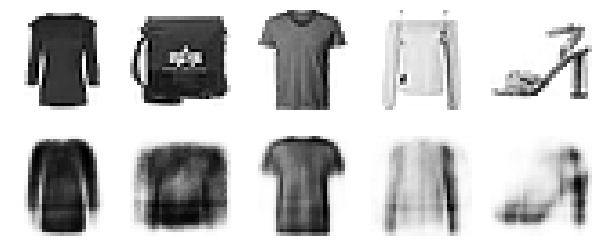

In [23]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

In [24]:
stacked_ae_1_by_1.compile(keras.optimizers.experimental.SGD(0.1), 'binary_crossentropy', [rounded_accuracy])
# history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = stacked_ae_1_by_1.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/6
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2861 - rounded_accuracy: 0.9357 - val_loss: 0.2878 - val_rounded_accuracy: 0.9356
Epoch 2/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2858 - rounded_accuracy: 0.9360 - val_loss: 0.2875 - val_rounded_accuracy: 0.9358
Epoch 3/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2856 - rounded_accuracy: 0.9362 - val_loss: 0.2874 - val_rounded_accuracy: 0.9364
Epoch 4/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2855 - rounded_accuracy: 0.9363 - val_loss: 0.2872 - val_rounded_accuracy: 0.9363
Epoch 5/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2854 - rounded_accuracy: 0.9364 - val_loss: 0.2871 - val_rounded_accuracy: 0.9364
Epoch 6/6
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2853 - rounded_accuracy: 0.9365 - val_loss: 0.2870 - val_rounded_accuracy: 0.9363


1/1 [==============================] - 0s 71ms/step


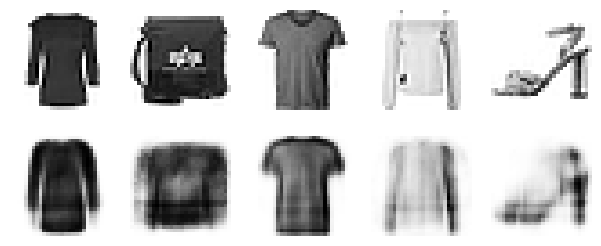

In [25]:
show_reconstructions(stacked_ae_1_by_1)
plt.show()

## 합성곱 오토인코더

3개의 은닉층과 1개의 출력층(즉, 두 개를 적층)을 가진 적층 오토인코더를 만든다.

In [26]:
conv_encoder = keras.Sequential(
    [
        keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
        keras.layers.Conv2D(16, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(32, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2),
        keras.layers.Conv2D(64, 3, padding='same', activation='selu'),
        keras.layers.MaxPool2D(2)
    ]
)
conv_decoder = keras.Sequential(
    [
        keras.layers.Conv2DTranspose(32, 3, 2, activation='selu', input_shape=[3, 3, 64]),
        keras.layers.Conv2DTranspose(16, 3, 2, 'same', activation='selu'),
        keras.layers.Conv2DTranspose(1, 3, 2, 'same', activation='sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
conv_ae = keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(keras.optimizers.experimental.SGD(1.0), 'binary_crossentropy', [rounded_accuracy])
# history = conv_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))
history = conv_ae.fit(X_train, X_train, epochs=4, validation_data=(X_valid, X_valid))

Epoch 1/4
1719/1719 [==============================] - 27s 8ms/step - loss: 0.3005 - rounded_accuracy: 0.9190 - val_loss: 0.2813 - val_rounded_accuracy: 0.9342
Epoch 2/4
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2756 - rounded_accuracy: 0.9410 - val_loss: 0.2725 - val_rounded_accuracy: 0.9464
Epoch 3/4
1719/1719 [==============================] - 14s 8ms/step - loss: 0.2710 - rounded_accuracy: 0.9457 - val_loss: 0.2694 - val_rounded_accuracy: 0.9494
Epoch 4/4
1719/1719 [==============================] - 13s 8ms/step - loss: 0.2684 - rounded_accuracy: 0.9485 - val_loss: 0.2690 - val_rounded_accuracy: 0.9493


In [27]:
conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)        

1/1 [==============================] - 0s 162ms/step


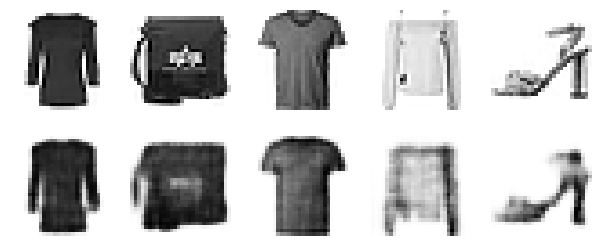

In [28]:
show_reconstructions(conv_ae)
plt.show()

## 순환 오토인코더

In [29]:
recurrent_encoder = keras.Sequential(
    [keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]), keras.layers.LSTM(30)]
)
recurrent_decoder = keras.Sequential(
    [
        keras.layers.RepeatVector(28, input_shape=[30]),
        keras.layers.LSTM(100, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(28, 'sigmoid'))
    ]
)
recurrent_ae = keras.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(keras.optimizers.experimental.SGD(0.1), 'binary_crossentropy', [rounded_accuracy])

In [30]:
# history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = recurrent_ae.fit(X_train, X_train, validation_data=(X_valid, X_valid))

1719/1719 [==============================] - 39s 19ms/step - loss: 0.5094 - rounded_accuracy: 0.7598 - val_loss: 0.4404 - val_rounded_accuracy: 0.8213


1/1 [==============================] - 1s 916ms/step


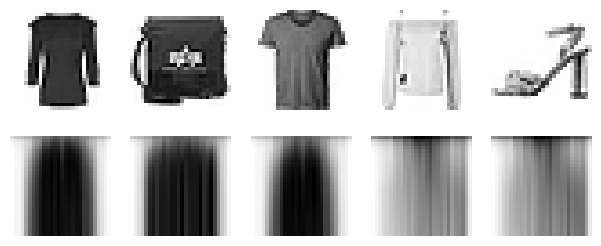

In [31]:
show_reconstructions(recurrent_ae)
plt.show()

## 잡음 제거 오토인코더

가우시안 잡음을 사용한다:

In [32]:
denoising_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.GaussianNoise(0.2),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(30, 'selu')
    ]
)
denoising_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
denoising_ae = keras.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(keras.optimizers.experimental.SGD(1.0), 'binary_crossentropy', [rounded_accuracy])
# history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = denoising_ae.fit(X_train, X_train, epochs=6, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3489 - rounded_accuracy: 0.8786 - val_loss: 0.3236 - val_rounded_accuracy: 0.9051
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3134 - rounded_accuracy: 0.9085 - val_loss: 0.3101 - val_rounded_accuracy: 0.9153
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3056 - rounded_accuracy: 0.9153 - val_loss: 0.3028 - val_rounded_accuracy: 0.9207
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3015 - rounded_accuracy: 0.9189 - val_loss: 0.3000 - val_rounded_accuracy: 0.9234
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2984 - rounded_accuracy: 0.9217 - val_loss: 0.2967 - val_rounded_accuracy: 0.9263
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2963 - rounded_accuracy: 0.9235 - val_loss: 0.2943 - val_rounded_accuracy: 0.9268
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 25ms/step


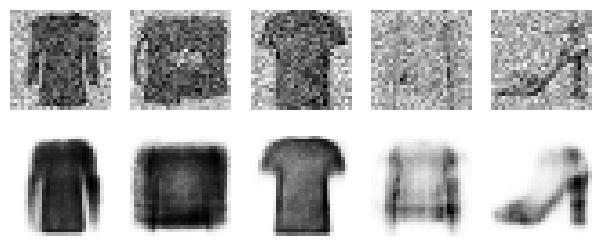

In [39]:
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, True))
plt.show()

드롭아웃을 사용한다:

In [40]:
dropout_encoder = keras.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(100, 'selu'),
        keras.layers.Dense(30, 'selu')
    ]
)
dropout_decoder = keras.Sequential(
    [
        keras.layers.Dense(100, 'selu', input_shape=[30]),
        keras.layers.Dense(28 * 28, 'sigmoid'),
        keras.layers.Reshape([28, 28])
    ]
)
dropout_ae = keras.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(keras.optimizers.experimental.SGD(1.0), 'binary_crossentropy', [rounded_accuracy])
# history = dropout_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))
history = dropout_ae.fit(X_train, X_train, epochs=5, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3569 - rounded_accuracy: 0.8711 - val_loss: 0.3203 - val_rounded_accuracy: 0.9023
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3187 - rounded_accuracy: 0.9027 - val_loss: 0.3125 - val_rounded_accuracy: 0.9087
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3129 - rounded_accuracy: 0.9073 - val_loss: 0.3070 - val_rounded_accuracy: 0.9148
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3094 - rounded_accuracy: 0.9101 - val_loss: 0.3046 - val_rounded_accuracy: 0.9165
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3069 - rounded_accuracy: 0.9120 - val_loss: 0.3020 - val_rounded_accuracy: 0.9186
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3050 - rounded_accuracy: 0.9137 - val_loss: 0.3006 - val_rounded_accuracy: 0.9204
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 22ms/step
그림 저장 dropout_denoising_plot


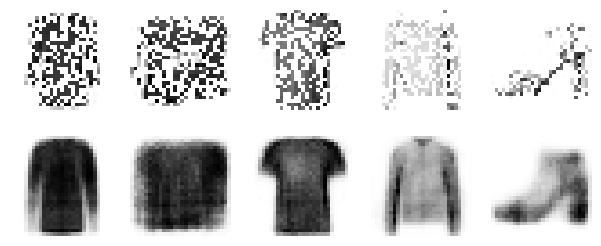

In [43]:
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, True))
save_fig('dropout_denoising_plot', False)